<a href="https://colab.research.google.com/github/NunezKant/iGEDS/blob/master/GED_141_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se incluyen librerías necesarias:

In [164]:
! pip install pingouin
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

Cargamos los datos:

In [165]:
df = pd.read_csv('https://raw.githubusercontent.com/NunezKant/iGEDS/master/iEcosystems%20(141%20countries%20dataset)%20-%20Indicators.csv', decimal=",")
df.tail()

,Country,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
138,"Yemen, Rep.",31.8,76.8,74.1,26.9,48.5,22.5,21.9,43.8,70.0,14,NaN,28.81,45.20,NaN,NaN,NaN,NaN,NaN,NaN,5.48,2.35,2.71,NaN,2.60,19.5,51.2,0.39,NaN,NaN,7.3,NaN,23.31,19.39,0.0,NaN,NaN,2.27,63.96,17.63,25.78,41.3,NaN,NaN,NaN,NaN,43.9,40.39,30.79,NaN,NaN,NaN,18.8,34.4,0.15,60.8,44.961002,2.26559,873.38,-8.16,0.8,13.5,-0.68,940.0,17.0
139,Zambia,66.9,84.9,88.9,49.3,50.8,45.2,28.4,47.0,72.6,35,NaN,45.98,62.69,0.3,NaN,NaN,NaN,NaN,NaN,3.92,3.13,3.98,31.1,3.48,31.6,53.5,0.42,NaN,NaN,2.6,10.5,34.40,13.39,95.0,3.3,237.5,2.49,60.81,34.23,26.57,41.3,NaN,NaN,NaN,NaN,66.4,47.77,41.67,3.4,NaN,2.99,57.5,44.5,0.06,54.0,24.703230,8.40045,1416.72,0.48,1.7,7.9,2.11,1450.0,29.4
140,Zimbabwe,54.5,72.0,58.7,32.9,39.7,33.7,18.9,43.1,70.0,22,NaN,49.25,56.25,0.9,NaN,NaN,NaN,NaN,NaN,9.12,2.68,3.87,36.0,1.98,26.7,49.2,0.38,59.2,NaN,6.1,NaN,32.80,17.63,55.0,NaN,NaN,2.17,59.93,37.36,30.39,33.3,NaN,NaN,NaN,NaN,39.1,53.88,31.43,NaN,46.5,2.84,21.4,46.6,0.35,25.1,19


*   Guardamos minimos y maximos
*   Eliminamos dichas filas del df
*   Hacemos set del país como indice del df



In [166]:
mins = df.iloc[141,1:].astype('float').values
maxs = df.iloc[142,1:].astype('float').values
df = (df.drop(axis = 0, index=141)
        .drop(axis = 0, index = 142)
)
df.set_index('Country', inplace = True)

Re-escalamos a valores entre 1-5 

In [167]:
for col,val1,val2 in zip(df.columns,mins,maxs):
  df[col] = df[col].apply(lambda x: (x-val1)/(val2-val1))

scaled = np.round((df*4)+1,3)

In [168]:
scaled.tail()

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Venezuela, RB",2.208,2.000,1.456,1.740,2.876,1.404,1.584,2.108,3.320,1.72,NaN,3.114,2.593,NaN,NaN,NaN,NaN,NaN,NaN,1.015,2.313,2.393,NaN,1.540,NaN,NaN,1.090,NaN,NaN,NaN,NaN,2.167,1.710,NaN,NaN,NaN,2.37,4.370,2.870,1.822,NaN,NaN,NaN,NaN,NaN,2.232,3.038,2.035,NaN,NaN,NaN,4.467,4.150,3.071,3.672,4.525,1.456,1.146,-0.775,NaN,2.550,2.253,NaN,2.740
Vietnam,3.792,4.404,3.760,2.520,3.484,3.104,2.352,3.500,4.184,2.32,NaN,2.650,2.972,1.336,NaN,1.427,1.025,1.851,1.384,1.074,2.660,2.973,2.952,2.760,2.544,3.772,1.169,2.524,NaN,1.876,1.277,2.749,2.512,4.0,1.324,1.026,3.16,4.847,3.761,2.912,3.584,NaN,NaN,NaN,NaN,3.624,2.939,3.105,2.667,NaN,2.987,4.896,4.233,2.929,3.938,3.871,1.933,1.107,4.552,4.626,4.749,2.833,1.105,3.008
"Yemen, Rep.",2.272,4.072,3.964,2.076,2.940,1.900,1.876,2.752,3.800,1.56,NaN,2.152,2.808,NaN,NaN,NaN,NaN,NaN,NaN,1.004,1.900,2.140,NaN,2.067,1.780,3.048,1.016,NaN,NaN,

Inputamos por método de KNN con 5 vecinos como parámetro, los valores fuera de los limites dados, se toparon a 1 o 5 respectivamente.

In [169]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
var = imputer.fit_transform(scaled)
var = np.where(var>5,5,var)
var = np.where(var<1,1,var)
df_imputed = pd.DataFrame(var)
df_imputed.columns = df.columns
df_imputed.index = df.index
df_imputed.head(6)

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,3.708,4.672,3.608,3.708,3.140,3.284,2.552,3.084,4.536,2.44,1.4650,3.196,2.928,1.0680,2.3730,1.2006,1.0038,1.732,1.1560,1.046,2.987,3.2400,3.1240,2.9330,2.5520,3.3040,1.000,2.1320,3.8126,2.7880,1.1000,2.905,2.343,3.80,1.1632,1.0010,2.62,4.701,3.115,2.382,2.3560,2.8610,2.7282,3.4926,3.3098,3.628,2.560,2.216,1.9330,3.863,3.0530,4.943,4.723,4.571,3.7850,4.428,1.847,1.239,4.036,3.245,2.993,3.041,1.237,3.172
Algeria,2.944,4.120,3.156,2.968,3.192,2.516,2.132,3.020,3.648,2.40,1.3844,2.792,3.081,1.3920,2.5406,1.4400,1.0250,3.213,1.0310,1.032,2.527,2.8530,3.1240,2.3400,2.0760,3.3040,1.391,3.4640,3.8696,2.4960,1.2590,2.878,2.656,1.40,1.5304,1.0230,2.56,4.751,3.109,2.856,3.5560,3.1934,3.0822,3.6602,3.6130,3.520,2.740,2.932,1.8670,3.682,3.1470,4.974,4.797,3.786,3.7442,3.610,1.733,1.188,2.997,2.842,3.524,2.291,1.175,2.724
Angola,2.652,4.176,3.780,1.000,2.124,2.476,1.604,3.444,3

In [170]:
#@title Funcion de regresión
def check_corr_significance(df,a,b):
  import scipy.stats as stats
  r = stats.pearsonr(df[a], df[b])
  print(f'Correlation between:  ' + a + '   and   ' + b)
  print('**********************************************')
  print(f'Pearson Correlation: {r[0]}, p-value: {r[1]}')
  if r[1] < 0.05:
    print('*Statistically significant*')
  else:
    print('Not significant')

  print('**********************************************')
  print('')

  sns.lmplot(x=b, y=a, data=df)

Correlation between:  1.02 Starting a business (WB)   and   GNI per capita (WB)
**********************************************
Pearson Correlation: 0.3605392009272578, p-value: 1.1247532032004746e-05
*Statistically significant*
**********************************************



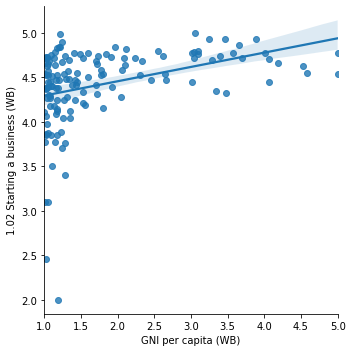

In [175]:
check_corr_significance(df_imputed,'1.02 Starting a business (WB)','GNI per capita (WB)')